In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_gbq

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

import fbprophet

from ArapFunctions import query_table, prep_data_for_tsmodel, view_predictions

In [2]:
sql_query = """
SELECT 
  asin,
  product_title,
  category,
  subcategory,
  ordered_units,
  shipped_units,
  subcategory_sales_rank,
  average_sales_price,
  change_in_gv_prior_period,
  change_in_impressions_prior_period,
  start_date,
  end_date, 
  country
    
FROM 
  `cp-gaa-visualization-dev.arap.sales_diagnostic_detail_dly`
  
WHERE
  product_title LIKE "%Softsoap%" AND product_title LIKE "%Liquid Hand Soap%"

"""
sales_diag = query_table(sql_query)

Downloading: 100%|██████████| 496455/496455 [00:59<00:00, 8338.74rows/s]


In [4]:
lhs_daily = prep_data_for_tsmodel(sales_diag)
lhs_daily.head()

,ds,y
0,2018-01-13,5572
1,2018-01-14,6648
2,2018-01-15,8808
3,2018-01-16,9454
4,2018-01-17,7532


In [12]:
forecast_model = fbprophet.Prophet(changepoint_prior_scale=0.3, daily_seasonality=True)
forecast_model.fit(lhs_daily)

In [13]:
arap_df = forecast_model.make_future_dataframe(periods=60, freq='D')
arap_preds = forecast_model.predict(arap_df)

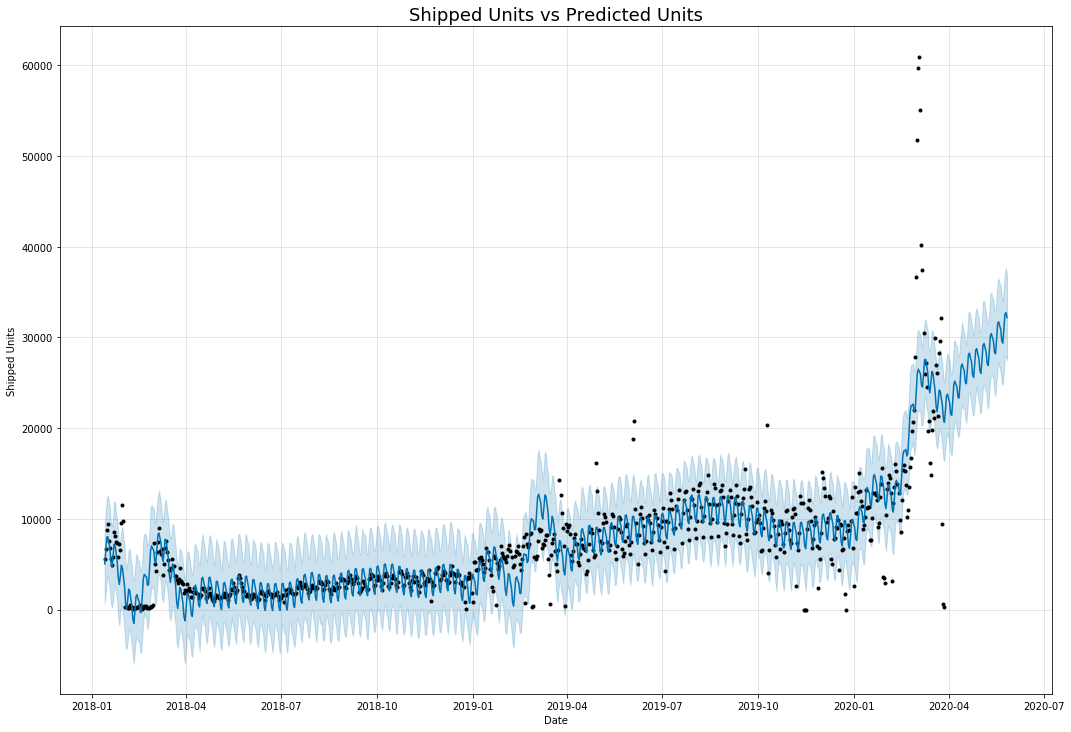

In [17]:
view_predictions(arap_preds)

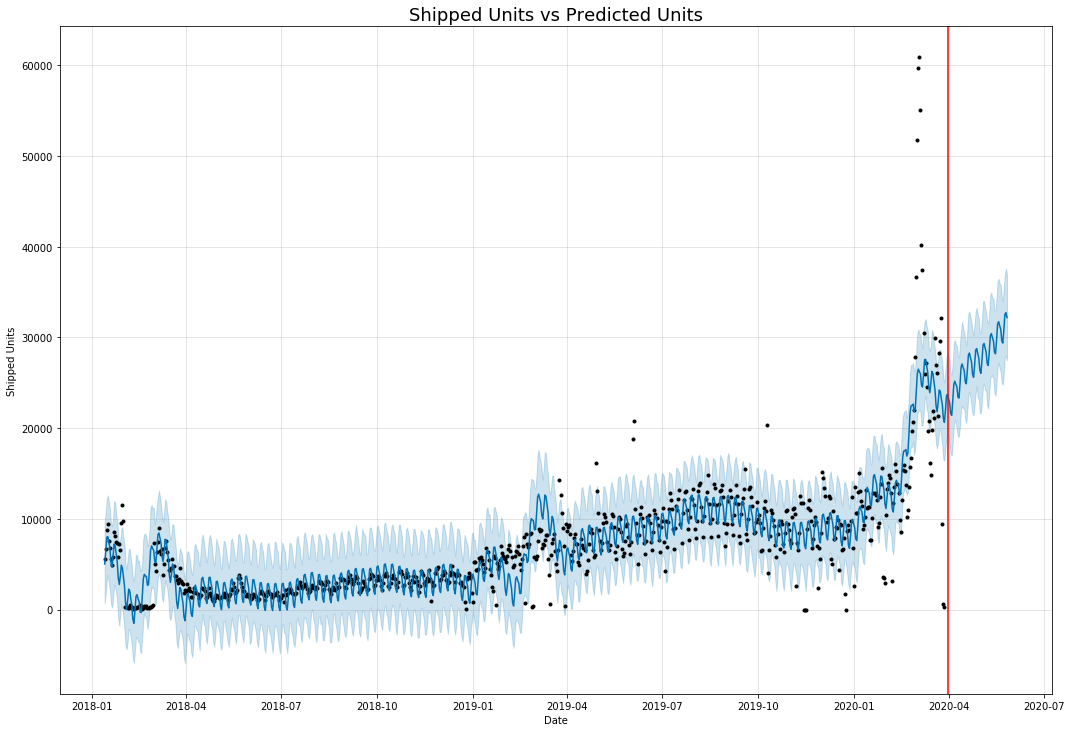

In [18]:
view_predictions(arap_preds, show_v_line=True)

<details><summary>What does this mean?</summary>
    
- The black dots represent the actual values (shipped units)
- The blue line indicates the forecasted values
- The light blue shaded region is the uncertainty
    - The region of uncertainty increases the further out in the future the prediction is made because initial uncertainty propagates and grows over time. 
</details>

In [21]:
lhs_daily_1 = lhs_daily.copy()
lhs_daily_1['predictions'] = arap_preds['yhat']
lhs_daily_1['difference'] = lhs_daily_1['y'].sub(lhs_daily_1['predictions'], axis = 0) 
lhs_daily_1.head()

,ds,y,predictions,difference
0,2018-01-13,5572,5029.023414,542.976586
1,2018-01-14,6648,6379.099915,268.900085
2,2018-01-15,8808,7967.340605,840.659395
3,2018-01-16,9454,8036.651221,1417.348779
4,2018-01-17,7532,7357.387639,174.612361


In [22]:
lhs_daily_1.tail(10)

,ds,y,predictions,difference
796,2020-03-19,29991,24219.828875,5771.171125
797,2020-03-20,27000,22475.639212,4524.360788
798,2020-03-21,26049,21805.587848,4243.412152
799,2020-03-22,21286,22861.073659,-1575.073659
800,2020-03-23,28264,24200.052167,4063.947833
801,2020-03-24,29552,24074.783052,5477.216948
802,2020-03-25,32150,23263.679441,8886.320559
803,2020-03-26,9397,22590.454365,-13193.454365
804,2020-03-27,554,21060.573468,-20506.573468
805,2020-03-28,294,20633.042181,-20339.042181


In [28]:
forecast_60 = arap_preds.loc[806:,['ds', 'yhat']]

In [29]:
forecast_60.tail()

,ds,yhat
861,2020-05-23,29375.294592
862,2020-05-24,30832.599551
863,2020-05-25,32535.695441
864,2020-05-26,32732.091916
865,2020-05-27,32196.581998


In [34]:
#arap_preds.loc[806:,['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
forecast_model.

## Full Bayesian Inference